## summary

* 2.5d segmentation
    *  segmentation_models_pytorch 
    *  Unet
* use only 7 slices in the middle
* slide inference

In [22]:
# !pip install -q ../input/pytorch-segmentation-models-lib/pretrainedmodels-0.7.4/pretrainedmodels-0.7.4
# !pip install -q ../input/pytorch-segmentation-models-lib/efficientnet_pytorch-0.6.3/efficientnet_pytorch-0.6.3
# !pip install -q ../input/pytorch-segmentation-models-lib/timm-0.4.12-py3-none-any.whl
# !pip install -q ../input/pytorch-segmentation-models-lib/segmentation_models_pytorch-0.2.0-py3-none-any.whl

In [23]:
# !mkdir -p /root/.cache/torch/hub/checkpoints/
# !cp ../input/efficientnet-b0-355c32eb.pth /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth

In [24]:
# !pip install torch==1.10.2+cu113 torchvision==0.11.3+cu113 torchaudio===0.10.2+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html

In [25]:

from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, log_loss
import pickle
from torch.utils.data import DataLoader
from torch.cuda.amp import autocast, GradScaler
import warnings
import sys
import pandas as pd
import os
import gc
import sys
import math
import time
import random
import shutil
from pathlib import Path
from contextlib import contextmanager
from collections import defaultdict, Counter
import cv2

import scipy as sp
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from functools import partial

import argparse
import importlib
import torch
import torch.nn as nn
from torch.optim import Adam, SGD, AdamW

import datetime

In [26]:
# sys.path.append('/kaggle/input/pretrainedmodels/pretrainedmodels-0.7.4')
# sys.path.append('/kaggle/input/efficientnet-pytorch/EfficientNet-PyTorch-master')
# sys.path.append('/kaggle/input/timm-pytorch-image-models/pytorch-image-models-master')
# sys.path.append('/kaggle/input/segmentation-models-pytorch/segmentation_models.pytorch-master')

In [27]:
import segmentation_models_pytorch as smp

In [28]:
import numpy as np
from torch.utils.data import DataLoader, Dataset
import cv2
import torch
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

## config

In [29]:
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2

class CFG:
    # ============== comp exp name =============
    comp_name = 'vesuvius'

    # comp_dir_path = './'
    comp_dir_path = '../input/'
    comp_folder_name = 'vesuvius-challenge-ink-detection'
    # comp_dataset_path = f'{comp_dir_path}datasets/{comp_folder_name}/'
    comp_dataset_path = f'{comp_dir_path}{comp_folder_name}/'
    
    exp_name = 'resnet-exp017'#'vesuvius_2d_slide_exp002'

    # ============== pred target =============
    target_size = 1

    # ============== model cfg =============
    model_name = 'Unet'
    # backbone = 'efficientnet-b0'
    # backbone = 'se_resnext50_32x4d'
    backbone = 'se_resnext101_32x4d'

    in_chans = 8 # 65
    # ============== training cfg =============
    size = 224
    tile_size = 224
    stride = tile_size // 2

    train_batch_size = 16 # 32
    valid_batch_size = train_batch_size * 2
    use_amp = True

    scheduler = 'GradualWarmupSchedulerV2'
    # scheduler = 'CosineAnnealingLR'
    epochs = 30 # 15

    # adamW warmupあり
    warmup_factor = 10
    # lr = 1e-4 / warmup_factor
    lr = 1e-4 / warmup_factor

    # ============== fold =============
    valid_id = 1

    # objective_cv = 'binary'  # 'binary', 'multiclass', 'regression'
    metric_direction = 'maximize'  # maximize, 'minimize'
    # metrics = 'dice_coef'

    # ============== fixed =============
    pretrained = True
    inf_weight = 'best'  # 'best'

    min_lr = 1e-6
    weight_decay = 1e-6
    max_grad_norm = 1000

    print_freq = 50
    num_workers = 4

    seed = 42

    # ============== set dataset path =============
    print('set dataset path')

    outputs_path = f'../output/{comp_name}/{exp_name}/'

    submission_dir = outputs_path + 'submissions/'
    submission_path = submission_dir + f'submission_{exp_name}.csv'

    model_dir = outputs_path + \
        f'{comp_name}-models/'

    figures_dir = outputs_path + 'figures/'

    log_dir = outputs_path + 'logs/'
    log_path = log_dir + f'{exp_name}.txt'

    # ============== augmentation =============
    train_aug_list = [
        # A.RandomResizedCrop(
        #     size, size, scale=(0.85, 1.0)),
        A.Resize(size, size),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.75),
        A.ShiftScaleRotate(p=0.75),
        A.OneOf([
                A.GaussNoise(var_limit=[10, 50]),
                A.GaussianBlur(),
                A.MotionBlur(),
                ], p=0.4),
        A.GridDistortion(num_steps=5, distort_limit=0.3, p=0.5),
        A.CoarseDropout(max_holes=1, max_width=int(size * 0.3), max_height=int(size * 0.3), 
                        mask_fill_value=0, p=0.5),
        # A.Cutout(max_h_size=int(size * 0.6),
        #          max_w_size=int(size * 0.6), num_holes=1, p=1.0),
        A.Normalize(
            mean= [0] * in_chans,
            std= [1] * in_chans
        ),
        ToTensorV2(transpose_mask=True),
    ]

    valid_aug_list = [
        A.Resize(size, size),
        A.Normalize(
            mean= [0] * in_chans,
            std= [1] * in_chans
        ),
        ToTensorV2(transpose_mask=True),
    ]


set dataset path


## helper

In [30]:
class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [31]:
def init_logger(log_file):
    from logging import getLogger, INFO, FileHandler, Formatter, StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

def set_seed(seed=None, cudnn_deterministic=True):
    if seed is None:
        seed = 42

    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = cudnn_deterministic
    torch.backends.cudnn.benchmark = False

In [32]:
def make_dirs(cfg):
    for dir in [cfg.model_dir, cfg.figures_dir, cfg.submission_dir, cfg.log_dir]:
        os.makedirs(dir, exist_ok=True)

In [33]:
def cfg_init(cfg, mode='train'):
    set_seed(cfg.seed)
    # set_env_name()
    # set_dataset_path(cfg)

    if mode == 'train':
        make_dirs(cfg)

In [34]:
cfg_init(CFG)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Logger = init_logger(log_file=CFG.log_path)

Logger.info('\n\n-------- exp_info -----------------')
# Logger.info(datetime.datetime.now().strftime('%Y年%m月%d日 %H:%M:%S'))



-------- exp_info -----------------


-------- exp_info -----------------


## image, mask

In [35]:
def read_image_mask(fragment_id):

    images = []

    # idxs = range(65)
    mid = 65 // 2
    start = mid - CFG.in_chans // 2
    end = mid + CFG.in_chans // 2
    idxs = range(start, end)

    for i in tqdm(idxs):
        
        image = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/surface_volume/{i:02}.tif", 0)

        pad0 = (CFG.tile_size - image.shape[0] % CFG.tile_size)
        pad1 = (CFG.tile_size - image.shape[1] % CFG.tile_size)

        image = np.pad(image, [(0, pad0), (0, pad1)], constant_values=0)

        images.append(image)
    images = np.stack(images, axis=2)

    mask = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/inklabels.png", 0)
    mask = np.pad(mask, [(0, pad0), (0, pad1)], constant_values=0)

    mask = mask.astype('float32')
    mask /= 255.0
    
    return images, mask

In [36]:
def get_train_valid_dataset():
    train_images = []
    train_masks = []

    valid_images = []
    valid_masks = []
    valid_xyxys = []

    for fragment_id in range(1, 4):

        image, mask = read_image_mask(fragment_id)

        x1_list = list(range(0, image.shape[1]-CFG.tile_size+1, CFG.stride))
        y1_list = list(range(0, image.shape[0]-CFG.tile_size+1, CFG.stride))

        for y1 in y1_list:
            for x1 in x1_list:
                y2 = y1 + CFG.tile_size
                x2 = x1 + CFG.tile_size
                # xyxys.append((x1, y1, x2, y2))
        
                if fragment_id == CFG.valid_id:
                    valid_images.append(image[y1:y2, x1:x2])
                    valid_masks.append(mask[y1:y2, x1:x2, None])

                    valid_xyxys.append([x1, y1, x2, y2])
                else:
                    train_images.append(image[y1:y2, x1:x2])
                    train_masks.append(mask[y1:y2, x1:x2, None])

    return train_images, train_masks, valid_images, valid_masks, valid_xyxys

In [37]:
train_images, train_masks, valid_images, valid_masks, valid_xyxys = get_train_valid_dataset()

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

In [38]:
# valid_xyxys = np.stack(valid_xyxys)

## dataset

In [39]:
import numpy as np
from torch.utils.data import DataLoader, Dataset
import cv2
import torch
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

In [40]:
def get_transforms(data, cfg):
    if data == 'train':
        aug = A.Compose(cfg.train_aug_list)
    elif data == 'valid':
        aug = A.Compose(cfg.valid_aug_list)

    # print(aug)
    return aug

class CustomDataset(Dataset):
    def __init__(self, images, cfg, labels=None, transform=None):
        self.images = images
        self.cfg = cfg
        self.labels = labels
        self.transform = transform

    def __len__(self):
        # return len(self.df)
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            data = self.transform(image=image, mask=label)
            image = data['image']
            label = data['mask']

        return image, label

In [41]:

train_dataset = CustomDataset(
    train_images, CFG, labels=train_masks, transform=get_transforms(data='train', cfg=CFG))
valid_dataset = CustomDataset(
    valid_images, CFG, labels=valid_masks, transform=get_transforms(data='valid', cfg=CFG))

train_loader = DataLoader(train_dataset,
                          batch_size=CFG.train_batch_size,
                          shuffle=True,
                          num_workers=CFG.num_workers, pin_memory=True, drop_last=True,
                          )
valid_loader = DataLoader(valid_dataset,
                          batch_size=CFG.valid_batch_size,
                          shuffle=False,
                          num_workers=CFG.num_workers, pin_memory=True, drop_last=False)


In [42]:
train_dataset[0][0].shape

torch.Size([8, 224, 224])

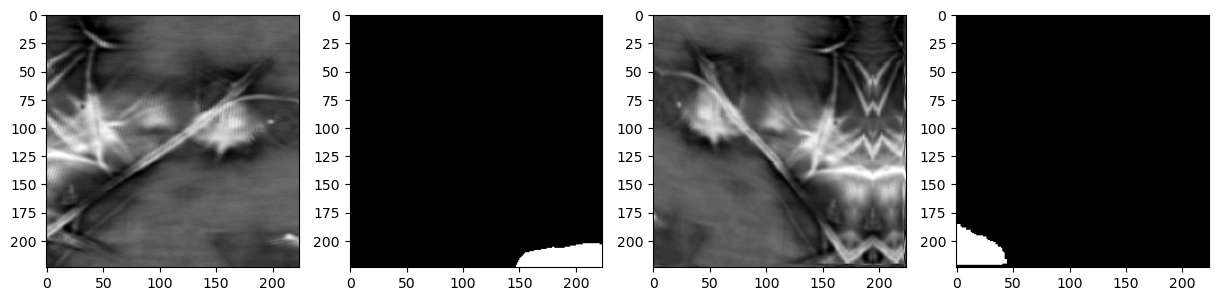

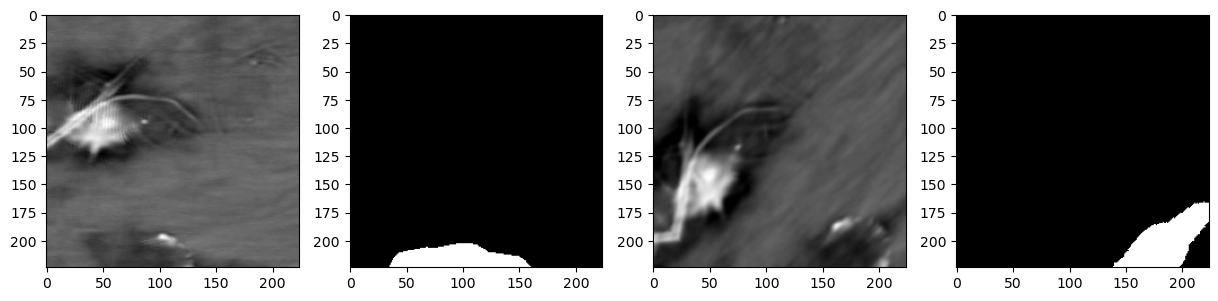

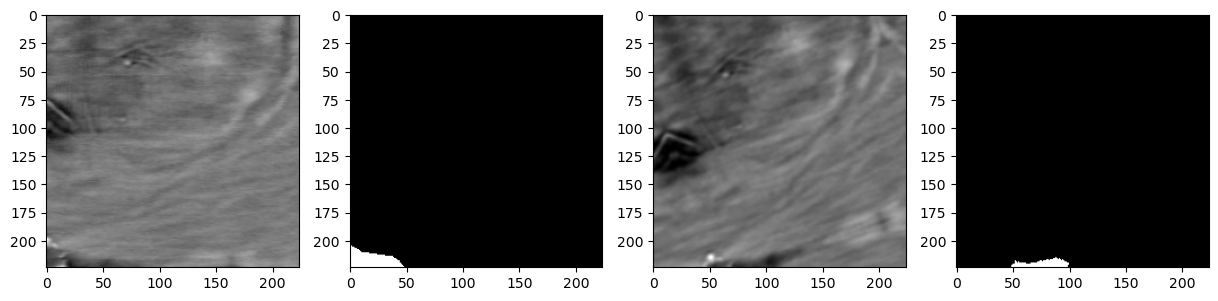

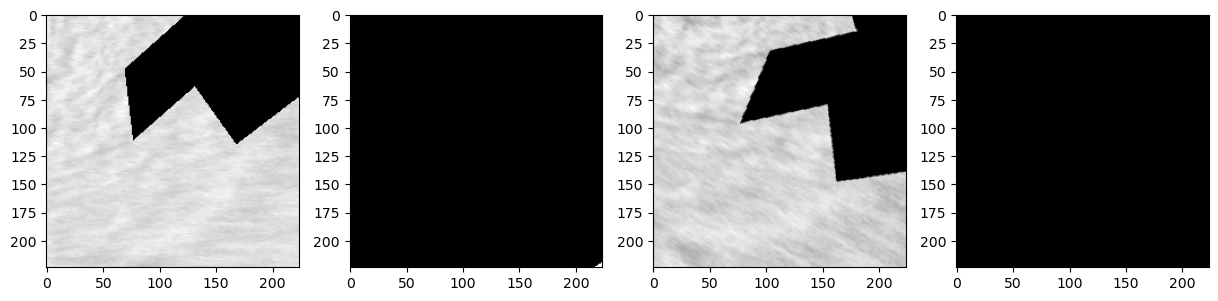

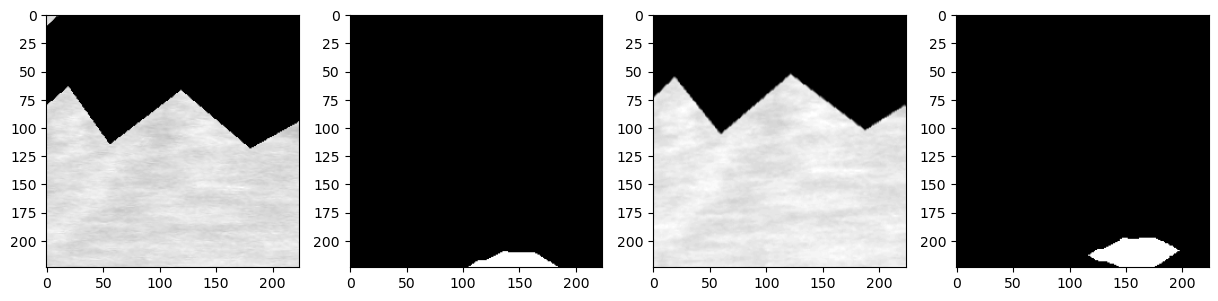

In [43]:

plot_dataset = CustomDataset(
    train_images, CFG, labels=train_masks)

transform = CFG.train_aug_list
transform = A.Compose(
    [t for t in transform if not isinstance(t, (A.Normalize, ToTensorV2))])


plot_count = 0
for i in range(1000):

    image, mask = plot_dataset[i]
    data = transform(image=image, mask=mask)
    aug_image = data['image']
    aug_mask = data['mask']

    if mask.sum() == 0:
        continue

    fig, axes = plt.subplots(1, 4, figsize=(15, 8))
    axes[0].imshow(image[..., 0], cmap="gray")
    axes[1].imshow(mask, cmap="gray")
    axes[2].imshow(aug_image[..., 0], cmap="gray")
    axes[3].imshow(aug_mask, cmap="gray")
    
    plt.savefig(CFG.figures_dir + f'aug_fold_{CFG.valid_id}_{plot_count}.png')

    plot_count += 1
    if plot_count == 5:
        break

In [44]:
del plot_dataset
gc.collect()

48133

## model

In [45]:
class CustomModel(nn.Module):
    def __init__(self, cfg, weight=None):
        super().__init__()
        self.cfg = cfg

        self.encoder = smp.Unet(
            encoder_name=cfg.backbone, 
            encoder_weights=weight,
            in_channels=cfg.in_chans,
            classes=cfg.target_size,
            activation=None,
        )

    def forward(self, image):
        output = self.encoder(image)
        # output = output.squeeze(-1)
        return output


def build_model(cfg, weight="imagenet"):
    print('model_name', cfg.model_name)
    print('backbone', cfg.backbone)

    model = CustomModel(cfg, weight)

    return model

In [46]:
# def build_model():
#     model = smp.Unet(
#         encoder_name=CFG.backbone,      # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
#         encoder_weights=None,     # use `imagenet` pre-trained weights for encoder initialization
#         in_channels=CFG.in_chans,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
#         classes=CFG.target_size,        # model output channels (number of classes in your dataset)
#         activation=None,
#     )
#     model.to(CFG.device)
#     return model

# def load_model(path):
#     model = build_model()
#     model.load_state_dict(torch.load(path))
#     model.eval()
#     return model

## scheduler

In [47]:

import torch.nn as nn
import torch
import math
import time
import numpy as np
import torch

from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau
from warmup_scheduler import GradualWarmupScheduler


class GradualWarmupSchedulerV2(GradualWarmupScheduler):
    """
    https://www.kaggle.com/code/underwearfitting/single-fold-training-of-resnet200d-lb0-965
    """
    def __init__(self, optimizer, multiplier, total_epoch, after_scheduler=None):
        super(GradualWarmupSchedulerV2, self).__init__(
            optimizer, multiplier, total_epoch, after_scheduler)

    def get_lr(self):
        if self.last_epoch > self.total_epoch:
            if self.after_scheduler:
                if not self.finished:
                    self.after_scheduler.base_lrs = [
                        base_lr * self.multiplier for base_lr in self.base_lrs]
                    self.finished = True
                return self.after_scheduler.get_lr()
            return [base_lr * self.multiplier for base_lr in self.base_lrs]
        if self.multiplier == 1.0:
            return [base_lr * (float(self.last_epoch) / self.total_epoch) for base_lr in self.base_lrs]
        else:
            return [base_lr * ((self.multiplier - 1.) * self.last_epoch / self.total_epoch + 1.) for base_lr in self.base_lrs]

def get_scheduler(cfg, optimizer):
    scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer, cfg.epochs, eta_min=1e-7)
    scheduler = GradualWarmupSchedulerV2(
        optimizer, multiplier=10, total_epoch=1, after_scheduler=scheduler_cosine)

    return scheduler

def scheduler_step(scheduler, avg_val_loss, epoch):
    scheduler.step(epoch)


In [48]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [49]:
model = build_model(CFG)
model.to(device)

optimizer = AdamW(model.parameters(), lr=CFG.lr)
scheduler = get_scheduler(CFG, optimizer)

model_name Unet
backbone se_resnext101_32x4d


## loss

In [50]:

DiceLoss = smp.losses.DiceLoss(mode='binary')
BCELoss = smp.losses.SoftBCEWithLogitsLoss()

alpha = 0.5
beta = 1 - alpha
TverskyLoss = smp.losses.TverskyLoss(
    mode='binary', log_loss=False, alpha=alpha, beta=beta)

def criterion(y_pred, y_true):
    # return 0.5 * BCELoss(y_pred, y_true) + 0.5 * DiceLoss(y_pred, y_true)
    return BCELoss(y_pred, y_true)
    # return 0.5 * BCELoss(y_pred, y_true) + 0.5 * TverskyLoss(y_pred, y_true)

## train, val

In [51]:
def train_fn(train_loader, model, criterion, optimizer, device):
    model.train()

    scaler = GradScaler(enabled=CFG.use_amp)
    losses = AverageMeter()

    for step, (images, labels) in tqdm(enumerate(train_loader), total=len(train_loader)):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        with autocast(CFG.use_amp):
            y_preds = model(images)
            loss = criterion(y_preds, labels)

        losses.update(loss.item(), batch_size)
        scaler.scale(loss).backward()

        grad_norm = torch.nn.utils.clip_grad_norm_(
            model.parameters(), CFG.max_grad_norm)

        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()

    return losses.avg

def valid_fn(valid_loader, model, criterion, device, valid_xyxys, valid_mask_gt):
    mask_pred = np.zeros(valid_mask_gt.shape)
    mask_count = np.zeros(valid_mask_gt.shape)

    model.eval()
    losses = AverageMeter()

    for step, (images, labels) in tqdm(enumerate(valid_loader), total=len(valid_loader)):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        with torch.no_grad():
            y_preds = model(images)
            loss = criterion(y_preds, labels)
        losses.update(loss.item(), batch_size)

        # make whole mask
        y_preds = torch.sigmoid(y_preds).to('cpu').numpy()
        start_idx = step*CFG.valid_batch_size
        end_idx = start_idx + batch_size
        for i, (x1, y1, x2, y2) in enumerate(valid_xyxys[start_idx:end_idx]):
            mask_pred[y1:y2, x1:x2] += y_preds[i].squeeze(0)
            mask_count[y1:y2, x1:x2] += np.ones((CFG.tile_size, CFG.tile_size))

    print(f'mask_count_min: {mask_count.min()}')
    mask_pred /= mask_count
    return losses.avg, mask_pred

## metrics

In [52]:
from sklearn.metrics import fbeta_score

def fbeta_numpy(targets, preds, beta=0.5, smooth=1e-5):
    """
    https://www.kaggle.com/competitions/vesuvius-challenge-ink-detection/discussion/397288
    """
    y_true_count = targets.sum()
    ctp = preds[targets==1].sum()
    cfp = preds[targets==0].sum()
    beta_squared = beta * beta

    c_precision = ctp / (ctp + cfp + smooth)
    c_recall = ctp / (y_true_count + smooth)
    dice = (1 + beta_squared) * (c_precision * c_recall) / (beta_squared * c_precision + c_recall + smooth)

    return dice

def calc_fbeta(mask, mask_pred):
    mask = mask.astype(int).flatten()
    mask_pred = mask_pred.flatten()

    best_th = 0
    best_dice = 0
    for th in np.array(range(10, 50+1, 5)) / 100:
        
        # dice = fbeta_score(mask, (mask_pred >= th).astype(int), beta=0.5)
        dice = fbeta_numpy(mask, (mask_pred >= th).astype(int), beta=0.5)
        print(f'th: {th}, fbeta: {dice}')

        if dice > best_dice:
            best_dice = dice
            best_th = th
    
    Logger.info(f'best_th: {best_th}, fbeta: {best_dice}')
    return best_dice, best_th


def calc_cv(mask_gt, mask_pred):
    best_dice, best_th = calc_fbeta(mask_gt, mask_pred)

    return best_dice, best_th

## main

In [53]:
fragment_id = CFG.valid_id

valid_mask_gt = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/inklabels.png", 0)
valid_mask_gt = valid_mask_gt / 255
pad0 = (CFG.tile_size - valid_mask_gt.shape[0] % CFG.tile_size)
pad1 = (CFG.tile_size - valid_mask_gt.shape[1] % CFG.tile_size)
valid_mask_gt = np.pad(valid_mask_gt, [(0, pad0), (0, pad1)], constant_values=0)

In [54]:

fold = CFG.valid_id

if CFG.metric_direction == 'minimize':
    best_score = np.inf
elif CFG.metric_direction == 'maximize':
    best_score = -1

best_loss = np.inf

for epoch in range(CFG.epochs):

    start_time = time.time()

    # train
    avg_loss = train_fn(train_loader, model, criterion, optimizer, device)

    # eval
    avg_val_loss, mask_pred = valid_fn(
        valid_loader, model, criterion, device, valid_xyxys, valid_mask_gt)

    scheduler_step(scheduler, avg_val_loss, epoch)

    best_dice, best_th = calc_cv(valid_mask_gt, mask_pred)

    # score = avg_val_loss
    score = best_dice

    elapsed = time.time() - start_time

    Logger.info(
        f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
    # Logger.info(f'Epoch {epoch+1} - avgScore: {avg_score:.4f}')
    Logger.info(
        f'Epoch {epoch+1} - avgScore: {score:.4f}')

    if CFG.metric_direction == 'minimize':
        update_best = score < best_score
    elif CFG.metric_direction == 'maximize':
        update_best = score > best_score

    if update_best:
        best_loss = avg_val_loss
        best_score = score

        Logger.info(
            f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
        Logger.info(
            f'Epoch {epoch+1} - Save Best Loss: {best_loss:.4f} Model')
        
        torch.save({'model': model.state_dict(),
                    'preds': mask_pred},
                    CFG.model_dir + f'{CFG.model_name}_fold{fold}_best.pth')

  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0


/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:154: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


th: 0.1, fbeta: 0.13451325513940393
th: 0.15, fbeta: 0.22201511404423724
th: 0.2, fbeta: 0.23892263165437738
th: 0.25, fbeta: 0.2556035496749534
th: 0.3, fbeta: 0.2797476293104094
th: 0.35, fbeta: 0.3114049765388483
th: 0.4, fbeta: 0.341252200467771
th: 0.45, fbeta: 0.3385601183257578


best_th: 0.4, fbeta: 0.341252200467771
best_th: 0.4, fbeta: 0.341252200467771
Epoch 1 - avg_train_loss: 0.3992  avg_val_loss: 0.3344  time: 229s
Epoch 1 - avg_train_loss: 0.3992  avg_val_loss: 0.3344  time: 229s
Epoch 1 - avgScore: 0.3413
Epoch 1 - avgScore: 0.3413
Epoch 1 - Save Best Score: 0.3413 Model
Epoch 1 - Save Best Score: 0.3413 Model
Epoch 1 - Save Best Loss: 0.3344 Model
Epoch 1 - Save Best Loss: 0.3344 Model


th: 0.5, fbeta: 0.18519351016079816


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.23404345885673217
th: 0.15, fbeta: 0.2670260324402938
th: 0.2, fbeta: 0.29902255865019506
th: 0.25, fbeta: 0.32757387231520685
th: 0.3, fbeta: 0.3528377231518941
th: 0.35, fbeta: 0.37506928308111065
th: 0.4, fbeta: 0.38977020426880893
th: 0.45, fbeta: 0.3898943946263606


best_th: 0.45, fbeta: 0.3898943946263606
best_th: 0.45, fbeta: 0.3898943946263606
Epoch 2 - avg_train_loss: 0.3035  avg_val_loss: 0.2844  time: 231s
Epoch 2 - avg_train_loss: 0.3035  avg_val_loss: 0.2844  time: 231s
Epoch 2 - avgScore: 0.3899
Epoch 2 - avgScore: 0.3899
Epoch 2 - Save Best Score: 0.3899 Model
Epoch 2 - Save Best Score: 0.3899 Model
Epoch 2 - Save Best Loss: 0.2844 Model
Epoch 2 - Save Best Loss: 0.2844 Model


th: 0.5, fbeta: 0.31947830618083495


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0


/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:715: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


th: 0.1, fbeta: 0.32032857324963365
th: 0.15, fbeta: 0.35915049573887387
th: 0.2, fbeta: 0.394637543545103
th: 0.25, fbeta: 0.42337750596854784
th: 0.3, fbeta: 0.4457544528294748
th: 0.35, fbeta: 0.4619455186445971
th: 0.4, fbeta: 0.47534967706413284
th: 0.45, fbeta: 0.4845394734278223


best_th: 0.5, fbeta: 0.48603502923315467
best_th: 0.5, fbeta: 0.48603502923315467
Epoch 3 - avg_train_loss: 0.2594  avg_val_loss: 0.2315  time: 229s
Epoch 3 - avg_train_loss: 0.2594  avg_val_loss: 0.2315  time: 229s
Epoch 3 - avgScore: 0.4860
Epoch 3 - avgScore: 0.4860
Epoch 3 - Save Best Score: 0.4860 Model
Epoch 3 - Save Best Score: 0.4860 Model
Epoch 3 - Save Best Loss: 0.2315 Model
Epoch 3 - Save Best Loss: 0.2315 Model


th: 0.5, fbeta: 0.48603502923315467


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3823989811288939
th: 0.15, fbeta: 0.4166588753276269
th: 0.2, fbeta: 0.44148593522416674
th: 0.25, fbeta: 0.4584451638657437
th: 0.3, fbeta: 0.47440761901797507
th: 0.35, fbeta: 0.4872331537864439
th: 0.4, fbeta: 0.4956790411027838
th: 0.45, fbeta: 0.4964393855934723


best_th: 0.45, fbeta: 0.4964393855934723
best_th: 0.45, fbeta: 0.4964393855934723
Epoch 4 - avg_train_loss: 0.2316  avg_val_loss: 0.2347  time: 230s
Epoch 4 - avg_train_loss: 0.2316  avg_val_loss: 0.2347  time: 230s
Epoch 4 - avgScore: 0.4964
Epoch 4 - avgScore: 0.4964
Epoch 4 - Save Best Score: 0.4964 Model
Epoch 4 - Save Best Score: 0.4964 Model
Epoch 4 - Save Best Loss: 0.2347 Model
Epoch 4 - Save Best Loss: 0.2347 Model


th: 0.5, fbeta: 0.48591463190025286


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.35854464475190495
th: 0.15, fbeta: 0.3914879303890239
th: 0.2, fbeta: 0.41930008193859397
th: 0.25, fbeta: 0.43862377461359764
th: 0.3, fbeta: 0.4576516566463062
th: 0.35, fbeta: 0.47520371945570755
th: 0.4, fbeta: 0.4890911926710589
th: 0.45, fbeta: 0.49441837570918284


best_th: 0.45, fbeta: 0.49441837570918284
best_th: 0.45, fbeta: 0.49441837570918284
Epoch 5 - avg_train_loss: 0.2177  avg_val_loss: 0.2429  time: 230s
Epoch 5 - avg_train_loss: 0.2177  avg_val_loss: 0.2429  time: 230s
Epoch 5 - avgScore: 0.4944
Epoch 5 - avgScore: 0.4944


th: 0.5, fbeta: 0.49063348203717405


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.48166737521102665
th: 0.15, fbeta: 0.5142872196177289
th: 0.2, fbeta: 0.532916395740029
th: 0.25, fbeta: 0.5394058952035555
th: 0.3, fbeta: 0.5332026509125913
th: 0.35, fbeta: 0.5220605689267319
th: 0.4, fbeta: 0.5052619682149274
th: 0.45, fbeta: 0.48569705540188324


best_th: 0.25, fbeta: 0.5394058952035555
best_th: 0.25, fbeta: 0.5394058952035555
Epoch 6 - avg_train_loss: 0.2036  avg_val_loss: 0.2803  time: 230s
Epoch 6 - avg_train_loss: 0.2036  avg_val_loss: 0.2803  time: 230s
Epoch 6 - avgScore: 0.5394
Epoch 6 - avgScore: 0.5394
Epoch 6 - Save Best Score: 0.5394 Model
Epoch 6 - Save Best Score: 0.5394 Model
Epoch 6 - Save Best Loss: 0.2803 Model
Epoch 6 - Save Best Loss: 0.2803 Model


th: 0.5, fbeta: 0.46345452226247896


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3519100420021878
th: 0.15, fbeta: 0.3804470685621128
th: 0.2, fbeta: 0.4059187270460613
th: 0.25, fbeta: 0.42642384598580146
th: 0.3, fbeta: 0.44604579550116213
th: 0.35, fbeta: 0.4655581798541051
th: 0.4, fbeta: 0.4810291135770855
th: 0.45, fbeta: 0.49367234790317466


best_th: 0.5, fbeta: 0.500997350672327
best_th: 0.5, fbeta: 0.500997350672327
Epoch 7 - avg_train_loss: 0.1927  avg_val_loss: 0.2504  time: 231s
Epoch 7 - avg_train_loss: 0.1927  avg_val_loss: 0.2504  time: 231s
Epoch 7 - avgScore: 0.5010
Epoch 7 - avgScore: 0.5010


th: 0.5, fbeta: 0.500997350672327


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4439588937807861
th: 0.15, fbeta: 0.47052762022156064
th: 0.2, fbeta: 0.48546427573268636
th: 0.25, fbeta: 0.49261126973746416
th: 0.3, fbeta: 0.49556767640015625
th: 0.35, fbeta: 0.4929079321154438
th: 0.4, fbeta: 0.4880668855789196
th: 0.45, fbeta: 0.4818904212553791


best_th: 0.3, fbeta: 0.49556767640015625
best_th: 0.3, fbeta: 0.49556767640015625
Epoch 8 - avg_train_loss: 0.1809  avg_val_loss: 0.2806  time: 229s
Epoch 8 - avg_train_loss: 0.1809  avg_val_loss: 0.2806  time: 229s
Epoch 8 - avgScore: 0.4956
Epoch 8 - avgScore: 0.4956


th: 0.5, fbeta: 0.4719082223338481


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.39354871158432075
th: 0.15, fbeta: 0.41744213054097684
th: 0.2, fbeta: 0.4358326932128465
th: 0.25, fbeta: 0.454323038860278
th: 0.3, fbeta: 0.4629885520536137
th: 0.35, fbeta: 0.4692906841939927
th: 0.4, fbeta: 0.47388609855993735
th: 0.45, fbeta: 0.4759006833353935


best_th: 0.45, fbeta: 0.4759006833353935
best_th: 0.45, fbeta: 0.4759006833353935
Epoch 9 - avg_train_loss: 0.1680  avg_val_loss: 0.2860  time: 231s
Epoch 9 - avg_train_loss: 0.1680  avg_val_loss: 0.2860  time: 231s
Epoch 9 - avgScore: 0.4759
Epoch 9 - avgScore: 0.4759


th: 0.5, fbeta: 0.4727562703614863


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4153630477106142
th: 0.15, fbeta: 0.44547906208686305
th: 0.2, fbeta: 0.46494252633522815
th: 0.25, fbeta: 0.48001217309864785
th: 0.3, fbeta: 0.49184170644990205
th: 0.35, fbeta: 0.5011369539267398
th: 0.4, fbeta: 0.5080459849960803
th: 0.45, fbeta: 0.5112572990039818


best_th: 0.45, fbeta: 0.5112572990039818
best_th: 0.45, fbeta: 0.5112572990039818
Epoch 10 - avg_train_loss: 0.1617  avg_val_loss: 0.2782  time: 233s
Epoch 10 - avg_train_loss: 0.1617  avg_val_loss: 0.2782  time: 233s
Epoch 10 - avgScore: 0.5113
Epoch 10 - avgScore: 0.5113


th: 0.5, fbeta: 0.5090168668323503


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.46714147991791444
th: 0.15, fbeta: 0.4879948713922495
th: 0.2, fbeta: 0.49901364186688085
th: 0.25, fbeta: 0.5020875379069856
th: 0.3, fbeta: 0.4972324591508855
th: 0.35, fbeta: 0.48932081908092423
th: 0.4, fbeta: 0.48146142589610313
th: 0.45, fbeta: 0.4675236005951975


best_th: 0.25, fbeta: 0.5020875379069856
best_th: 0.25, fbeta: 0.5020875379069856
Epoch 11 - avg_train_loss: 0.1512  avg_val_loss: 0.3068  time: 230s
Epoch 11 - avg_train_loss: 0.1512  avg_val_loss: 0.3068  time: 230s
Epoch 11 - avgScore: 0.5021
Epoch 11 - avgScore: 0.5021


th: 0.5, fbeta: 0.44648279051141926


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4561755617539103
th: 0.15, fbeta: 0.48282872416843925
th: 0.2, fbeta: 0.4970991487049731
th: 0.25, fbeta: 0.5026474769610396
th: 0.3, fbeta: 0.5046757336842107
th: 0.35, fbeta: 0.5047469217200978
th: 0.4, fbeta: 0.5041579291509362
th: 0.45, fbeta: 0.5035767391426728


best_th: 0.35, fbeta: 0.5047469217200978
best_th: 0.35, fbeta: 0.5047469217200978
Epoch 12 - avg_train_loss: 0.1420  avg_val_loss: 0.3225  time: 232s
Epoch 12 - avg_train_loss: 0.1420  avg_val_loss: 0.3225  time: 232s
Epoch 12 - avgScore: 0.5047
Epoch 12 - avgScore: 0.5047


th: 0.5, fbeta: 0.5006044608517978


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4486968170691546
th: 0.15, fbeta: 0.47554895369323463
th: 0.2, fbeta: 0.49617554596073793
th: 0.25, fbeta: 0.5096723597302537
th: 0.3, fbeta: 0.5178067631372566
th: 0.35, fbeta: 0.5232456978248768
th: 0.4, fbeta: 0.5249211712583042
th: 0.45, fbeta: 0.5231181834274338


best_th: 0.4, fbeta: 0.5249211712583042
best_th: 0.4, fbeta: 0.5249211712583042
Epoch 13 - avg_train_loss: 0.1328  avg_val_loss: 0.3310  time: 234s
Epoch 13 - avg_train_loss: 0.1328  avg_val_loss: 0.3310  time: 234s
Epoch 13 - avgScore: 0.5249
Epoch 13 - avgScore: 0.5249


th: 0.5, fbeta: 0.5189294979660594


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3946734824220742
th: 0.15, fbeta: 0.4257789741602409
th: 0.2, fbeta: 0.4499876880893584
th: 0.25, fbeta: 0.46853076286416556
th: 0.3, fbeta: 0.4832021385862388
th: 0.35, fbeta: 0.49580499890406793
th: 0.4, fbeta: 0.5025453669124299
th: 0.45, fbeta: 0.5039559681933926


best_th: 0.45, fbeta: 0.5039559681933926
best_th: 0.45, fbeta: 0.5039559681933926
Epoch 14 - avg_train_loss: 0.1238  avg_val_loss: 0.2932  time: 232s
Epoch 14 - avg_train_loss: 0.1238  avg_val_loss: 0.2932  time: 232s
Epoch 14 - avgScore: 0.5040
Epoch 14 - avgScore: 0.5040


th: 0.5, fbeta: 0.5030441738188554


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3785674033171189
th: 0.15, fbeta: 0.40107696205643756
th: 0.2, fbeta: 0.4192948746834196
th: 0.25, fbeta: 0.43724200163154786
th: 0.3, fbeta: 0.45131453563195106
th: 0.35, fbeta: 0.46271471296010974
th: 0.4, fbeta: 0.47214892889739046
th: 0.45, fbeta: 0.47974945101543753


best_th: 0.5, fbeta: 0.4866586830194671
best_th: 0.5, fbeta: 0.4866586830194671
Epoch 15 - avg_train_loss: 0.1159  avg_val_loss: 0.3201  time: 234s
Epoch 15 - avg_train_loss: 0.1159  avg_val_loss: 0.3201  time: 234s
Epoch 15 - avgScore: 0.4867
Epoch 15 - avgScore: 0.4867


th: 0.5, fbeta: 0.4866586830194671


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.429940518873595
th: 0.15, fbeta: 0.45891503036799064
th: 0.2, fbeta: 0.4808228872421437
th: 0.25, fbeta: 0.5007913541404564
th: 0.3, fbeta: 0.5133721068706759
th: 0.35, fbeta: 0.5191969648416794
th: 0.4, fbeta: 0.519999547785668
th: 0.45, fbeta: 0.5166297267846571


best_th: 0.4, fbeta: 0.519999547785668
best_th: 0.4, fbeta: 0.519999547785668
Epoch 16 - avg_train_loss: 0.1107  avg_val_loss: 0.3147  time: 233s
Epoch 16 - avg_train_loss: 0.1107  avg_val_loss: 0.3147  time: 233s
Epoch 16 - avgScore: 0.5200
Epoch 16 - avgScore: 0.5200


th: 0.5, fbeta: 0.5106584745711571


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4056456033600527
th: 0.15, fbeta: 0.43445290297441475
th: 0.2, fbeta: 0.4559098714747068
th: 0.25, fbeta: 0.4719236658187323
th: 0.3, fbeta: 0.48445452323652627
th: 0.35, fbeta: 0.4935081994353164
th: 0.4, fbeta: 0.501339328541671
th: 0.45, fbeta: 0.5052575127231855


best_th: 0.45, fbeta: 0.5052575127231855
best_th: 0.45, fbeta: 0.5052575127231855
Epoch 17 - avg_train_loss: 0.1046  avg_val_loss: 0.3182  time: 232s
Epoch 17 - avg_train_loss: 0.1046  avg_val_loss: 0.3182  time: 232s
Epoch 17 - avgScore: 0.5053
Epoch 17 - avgScore: 0.5053


th: 0.5, fbeta: 0.5023401659680126


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.42973963886818656
th: 0.15, fbeta: 0.44984397876399124
th: 0.2, fbeta: 0.4649496707356218
th: 0.25, fbeta: 0.4758676373541653
th: 0.3, fbeta: 0.48384364915864997
th: 0.35, fbeta: 0.4885997287230315
th: 0.4, fbeta: 0.4938713321089793
th: 0.45, fbeta: 0.4974984519472115


best_th: 0.45, fbeta: 0.4974984519472115
best_th: 0.45, fbeta: 0.4974984519472115
Epoch 18 - avg_train_loss: 0.0961  avg_val_loss: 0.3650  time: 233s
Epoch 18 - avg_train_loss: 0.0961  avg_val_loss: 0.3650  time: 233s
Epoch 18 - avgScore: 0.4975
Epoch 18 - avgScore: 0.4975


th: 0.5, fbeta: 0.4938735019326416


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.43390496887915264
th: 0.15, fbeta: 0.457130895426926
th: 0.2, fbeta: 0.4746849896175337
th: 0.25, fbeta: 0.4897613131137612
th: 0.3, fbeta: 0.5014840106153817
th: 0.35, fbeta: 0.5105740596625817
th: 0.4, fbeta: 0.5163515933059695
th: 0.45, fbeta: 0.5189874790696076


best_th: 0.5, fbeta: 0.519084418626867
best_th: 0.5, fbeta: 0.519084418626867
Epoch 19 - avg_train_loss: 0.0926  avg_val_loss: 0.3551  time: 233s
Epoch 19 - avg_train_loss: 0.0926  avg_val_loss: 0.3551  time: 233s
Epoch 19 - avgScore: 0.5191
Epoch 19 - avgScore: 0.5191


th: 0.5, fbeta: 0.519084418626867


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.40842161429243995
th: 0.15, fbeta: 0.4272526069467365
th: 0.2, fbeta: 0.44149099877763825
th: 0.25, fbeta: 0.45528158965037097
th: 0.3, fbeta: 0.4671407803099319
th: 0.35, fbeta: 0.47474613363546664
th: 0.4, fbeta: 0.4794642039122446
th: 0.45, fbeta: 0.4831537545814039


best_th: 0.5, fbeta: 0.4888152150750064
best_th: 0.5, fbeta: 0.4888152150750064
Epoch 20 - avg_train_loss: 0.0869  avg_val_loss: 0.3850  time: 233s
Epoch 20 - avg_train_loss: 0.0869  avg_val_loss: 0.3850  time: 233s
Epoch 20 - avgScore: 0.4888
Epoch 20 - avgScore: 0.4888


th: 0.5, fbeta: 0.4888152150750064


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4372471192693808
th: 0.15, fbeta: 0.45844325767339833
th: 0.2, fbeta: 0.4774169390739466
th: 0.25, fbeta: 0.4931260386661831
th: 0.3, fbeta: 0.5019041450489354
th: 0.35, fbeta: 0.5070723080959887
th: 0.4, fbeta: 0.5105347546637272
th: 0.45, fbeta: 0.5122430724359995


best_th: 0.45, fbeta: 0.5122430724359995
best_th: 0.45, fbeta: 0.5122430724359995
Epoch 21 - avg_train_loss: 0.0836  avg_val_loss: 0.3700  time: 234s
Epoch 21 - avg_train_loss: 0.0836  avg_val_loss: 0.3700  time: 234s
Epoch 21 - avgScore: 0.5122
Epoch 21 - avgScore: 0.5122


th: 0.5, fbeta: 0.5120552390983916


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4324303360552131
th: 0.15, fbeta: 0.45277727334585444
th: 0.2, fbeta: 0.4709187677007215
th: 0.25, fbeta: 0.48719890729766224
th: 0.3, fbeta: 0.4996941490664102
th: 0.35, fbeta: 0.5064635901169169
th: 0.4, fbeta: 0.5103217593584284
th: 0.45, fbeta: 0.5114721452997664


best_th: 0.45, fbeta: 0.5114721452997664
best_th: 0.45, fbeta: 0.5114721452997664
Epoch 22 - avg_train_loss: 0.0774  avg_val_loss: 0.3788  time: 235s
Epoch 22 - avg_train_loss: 0.0774  avg_val_loss: 0.3788  time: 235s
Epoch 22 - avgScore: 0.5115
Epoch 22 - avgScore: 0.5115


th: 0.5, fbeta: 0.5074375877787458


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4381239388399138
th: 0.15, fbeta: 0.459690449115884
th: 0.2, fbeta: 0.476660639369455
th: 0.25, fbeta: 0.4902392404337622
th: 0.3, fbeta: 0.4974246530050818
th: 0.35, fbeta: 0.5038398188546309
th: 0.4, fbeta: 0.5097168093994695
th: 0.45, fbeta: 0.514212811608749


best_th: 0.5, fbeta: 0.5153872476957378
best_th: 0.5, fbeta: 0.5153872476957378
Epoch 23 - avg_train_loss: 0.0744  avg_val_loss: 0.4049  time: 233s
Epoch 23 - avg_train_loss: 0.0744  avg_val_loss: 0.4049  time: 233s
Epoch 23 - avgScore: 0.5154
Epoch 23 - avgScore: 0.5154


th: 0.5, fbeta: 0.5153872476957378


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4282211721478517
th: 0.15, fbeta: 0.44840867164016385
th: 0.2, fbeta: 0.4641711196414071
th: 0.25, fbeta: 0.47827079160705593
th: 0.3, fbeta: 0.48683296712585855
th: 0.35, fbeta: 0.49167672301049986
th: 0.4, fbeta: 0.4957243812775153
th: 0.45, fbeta: 0.4971826719535999


best_th: 0.5, fbeta: 0.49788614571129985
best_th: 0.5, fbeta: 0.49788614571129985
Epoch 24 - avg_train_loss: 0.0714  avg_val_loss: 0.4000  time: 234s
Epoch 24 - avg_train_loss: 0.0714  avg_val_loss: 0.4000  time: 234s
Epoch 24 - avgScore: 0.4979
Epoch 24 - avgScore: 0.4979


th: 0.5, fbeta: 0.49788614571129985


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.42259997449291814
th: 0.15, fbeta: 0.44421628117605694
th: 0.2, fbeta: 0.46051203386198286
th: 0.25, fbeta: 0.47481104292062787
th: 0.3, fbeta: 0.48445744432371657
th: 0.35, fbeta: 0.4907279646557129
th: 0.4, fbeta: 0.49669799452221003
th: 0.45, fbeta: 0.5023204184220024


best_th: 0.5, fbeta: 0.5072063987002866
best_th: 0.5, fbeta: 0.5072063987002866
Epoch 25 - avg_train_loss: 0.0682  avg_val_loss: 0.3891  time: 234s
Epoch 25 - avg_train_loss: 0.0682  avg_val_loss: 0.3891  time: 234s
Epoch 25 - avgScore: 0.5072
Epoch 25 - avgScore: 0.5072


th: 0.5, fbeta: 0.5072063987002866


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4222575994668355
th: 0.15, fbeta: 0.44298616794802237
th: 0.2, fbeta: 0.459484677879549
th: 0.25, fbeta: 0.4742052506391847
th: 0.3, fbeta: 0.48336677285371066
th: 0.35, fbeta: 0.4892445275968674
th: 0.4, fbeta: 0.4920139255734911
th: 0.45, fbeta: 0.496500830459489


best_th: 0.5, fbeta: 0.499128251605146
best_th: 0.5, fbeta: 0.499128251605146
Epoch 26 - avg_train_loss: 0.0664  avg_val_loss: 0.4053  time: 232s
Epoch 26 - avg_train_loss: 0.0664  avg_val_loss: 0.4053  time: 232s
Epoch 26 - avgScore: 0.4991
Epoch 26 - avgScore: 0.4991


th: 0.5, fbeta: 0.499128251605146


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.44303526897097695
th: 0.15, fbeta: 0.4584552689806812
th: 0.2, fbeta: 0.47129221423350615
th: 0.25, fbeta: 0.48329311607101316
th: 0.3, fbeta: 0.4900674997814833
th: 0.35, fbeta: 0.49529580751756286
th: 0.4, fbeta: 0.49842609690581385
th: 0.45, fbeta: 0.5005244952503506


best_th: 0.45, fbeta: 0.5005244952503506
best_th: 0.45, fbeta: 0.5005244952503506
Epoch 27 - avg_train_loss: 0.0655  avg_val_loss: 0.4338  time: 237s
Epoch 27 - avg_train_loss: 0.0655  avg_val_loss: 0.4338  time: 237s
Epoch 27 - avgScore: 0.5005
Epoch 27 - avgScore: 0.5005


th: 0.5, fbeta: 0.4993373457469849


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.44175872012762707
th: 0.15, fbeta: 0.45982871572683365
th: 0.2, fbeta: 0.4716822560300721
th: 0.25, fbeta: 0.48228883962657765
th: 0.3, fbeta: 0.4872990809205708
th: 0.35, fbeta: 0.49035345475034375
th: 0.4, fbeta: 0.49415399055182674
th: 0.45, fbeta: 0.4960469315896716


best_th: 0.45, fbeta: 0.4960469315896716
best_th: 0.45, fbeta: 0.4960469315896716
Epoch 28 - avg_train_loss: 0.0635  avg_val_loss: 0.4462  time: 234s
Epoch 28 - avg_train_loss: 0.0635  avg_val_loss: 0.4462  time: 234s
Epoch 28 - avgScore: 0.4960
Epoch 28 - avgScore: 0.4960


th: 0.5, fbeta: 0.49237868506281773


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.46065509740570926
th: 0.15, fbeta: 0.4785870460324408
th: 0.2, fbeta: 0.4900132758758641
th: 0.25, fbeta: 0.5003656228171038
th: 0.3, fbeta: 0.5062606469651041
th: 0.35, fbeta: 0.5101707135496792
th: 0.4, fbeta: 0.512978657453597
th: 0.45, fbeta: 0.5122485487633508


best_th: 0.4, fbeta: 0.512978657453597
best_th: 0.4, fbeta: 0.512978657453597
Epoch 29 - avg_train_loss: 0.0625  avg_val_loss: 0.4353  time: 235s
Epoch 29 - avg_train_loss: 0.0625  avg_val_loss: 0.4353  time: 235s
Epoch 29 - avgScore: 0.5130
Epoch 29 - avgScore: 0.5130


th: 0.5, fbeta: 0.5085155908860924


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.45150493190171387
th: 0.15, fbeta: 0.4668630796462738
th: 0.2, fbeta: 0.4803330037180348
th: 0.25, fbeta: 0.49078315522639004
th: 0.3, fbeta: 0.49778838897231475
th: 0.35, fbeta: 0.502819783994301
th: 0.4, fbeta: 0.5061770249731993
th: 0.45, fbeta: 0.5076603292419865


best_th: 0.45, fbeta: 0.5076603292419865
best_th: 0.45, fbeta: 0.5076603292419865
Epoch 30 - avg_train_loss: 0.0620  avg_val_loss: 0.4347  time: 236s
Epoch 30 - avg_train_loss: 0.0620  avg_val_loss: 0.4347  time: 236s
Epoch 30 - avgScore: 0.5077
Epoch 30 - avgScore: 0.5077


th: 0.5, fbeta: 0.5041828582578869


In [55]:
check_point = torch.load(
    CFG.model_dir + f'{CFG.model_name}_fold{fold}_{CFG.inf_weight}.pth', map_location=torch.device('cpu'))

In [56]:
mask_pred = check_point['preds']

In [57]:
best_dice, best_th  = calc_fbeta(valid_mask_gt, mask_pred)

th: 0.1, fbeta: 0.48166737521102665
th: 0.15, fbeta: 0.5142872196177289
th: 0.2, fbeta: 0.532916395740029
th: 0.25, fbeta: 0.5394058952035555
th: 0.3, fbeta: 0.5332026509125913
th: 0.35, fbeta: 0.5220605689267319
th: 0.4, fbeta: 0.5052619682149274
th: 0.45, fbeta: 0.48569705540188324


best_th: 0.25, fbeta: 0.5394058952035555
best_th: 0.25, fbeta: 0.5394058952035555


th: 0.5, fbeta: 0.46345452226247896


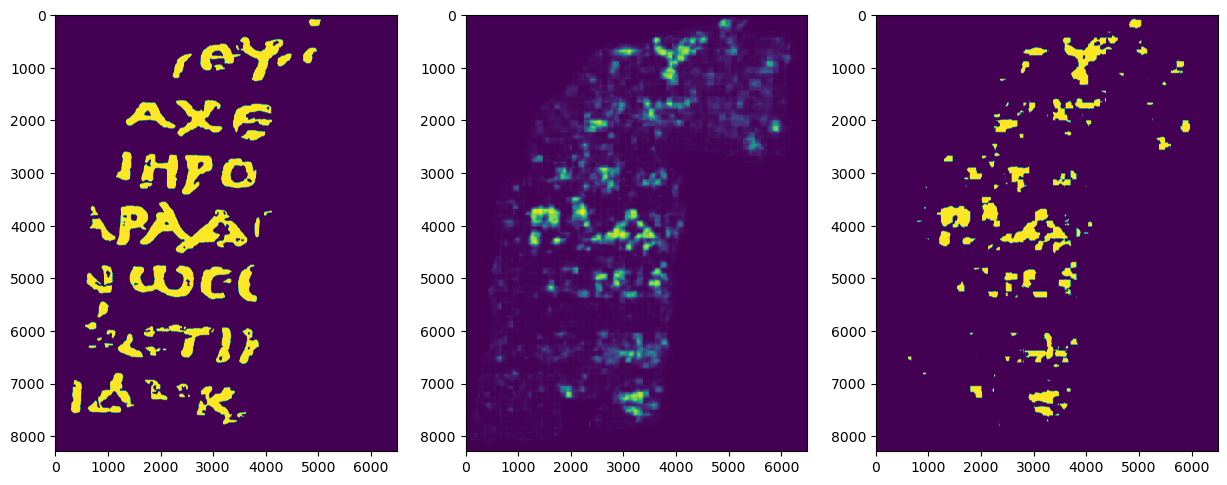

In [58]:
fig, axes = plt.subplots(1, 3, figsize=(15, 8))
axes[0].imshow(valid_mask_gt)
axes[1].imshow(mask_pred)
axes[2].imshow((mask_pred>=best_th).astype(int))

(array([4.4267333e+07, 4.0201170e+06, 1.5483060e+06, 8.8471900e+05,
        5.8188600e+05, 3.9990700e+05, 3.0012100e+05, 2.4157700e+05,
        2.2043500e+05, 1.8562000e+05, 1.7017200e+05, 1.4240200e+05,
        1.3982500e+05, 1.3305800e+05, 1.3368800e+05, 1.4453400e+05,
        1.5611900e+05, 1.0868200e+05, 4.7810000e+04, 1.2537000e+04]),
 array([6.03633289e-05, 4.88531995e-02, 9.76460356e-02, 1.46438872e-01,
        1.95231708e-01, 2.44024544e-01, 2.92817380e-01, 3.41610216e-01,
        3.90403052e-01, 4.39195889e-01, 4.87988725e-01, 5.36781561e-01,
        5.85574397e-01, 6.34367233e-01, 6.83160069e-01, 7.31952905e-01,
        7.80745741e-01, 8.29538578e-01, 8.78331414e-01, 9.27124250e-01,
        9.75917086e-01]),
 <BarContainer object of 20 artists>)

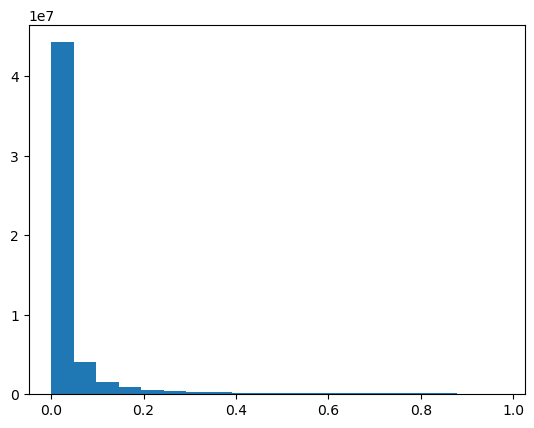

In [59]:
plt.hist(mask_pred.flatten(), bins=20)

In [60]:
# GPU VRAM 5.2GB/16.0GB A4000